In [63]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import chi2
from model.passive_model import FactorDynamicBasketModel
from statsmodels.tools.tools import add_constant
from scipy.stats import norm

# loading data
excel_pd = pd.read_excel("./data/raw_M.xlsx", "daily_data", index_col="Date")
answer = pd.read_excel("./data/answer.xlsx", "performance")
currency_vix = pd.read_excel("./currency_vix.xlsx", "static", index_col="Date")

# seting plot
meta_setup = {"figsize":(20, 10), "grid": True}

# select valid data
data = excel_pd.loc[excel_pd.index >= pd.to_datetime("1999-01-01")]
daily_return = data.pct_change()
answer = answer.dropna()[:-1]
all_vix = currency_vix
all_vix = all_vix.loc[all_vix.index >= pd.to_datetime("1999-01-01")].shift(1)
sigma_vix = ['VIX Index'] + [col for col in all_vix.columns if "V1M" in col]

# select first workday of the month
workdays = daily_return.index
first_workday_of_month = []
for i in range(1, len(workdays)):
    if workdays[i].month - workdays[i-1].month > 0:
        first_workday_of_month.append(workdays[i])
    elif workdays[i].month == 1 and workdays[i].month - workdays[i-1].month < 0:
        first_workday_of_month.append(workdays[i])
        
x_base_cncy = ["AUD", "XEU", "GBP"]
portfolio = ["JPY", "AUD", "KRW", "XEU", "SGD", "GBP"]

for asset in portfolio:
    if asset in x_base_cncy:
        data.loc[:, asset] = 1./data.loc[:, asset]


first_workday_of_month = pd.Index(first_workday_of_month)
montly_price = data.loc[first_workday_of_month[first_workday_of_month > pd.to_datetime("2002-02-11")]]
monthly_return = montly_price.pct_change().dropna()

C:\Users\i6800309\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [64]:
def corr_target(x, y):
    return (x * y)/(x.std() * y.std())

x = monthly_return['USD']
y = monthly_return['KRW']
implied_x_std = all_vix['USDTWDV1M Curncy']
implied_y_std = all_vix['USDKRWV1M Curncy']
cor = corr_target(x, y).clip(-2.5, 2.5)
target = (cor.subtract(1/implied_x_std).subtract(1/implied_y_std)).dropna()
factor = 1/(implied_x_std * implied_y_std)
print(monthly_return.corr())

          USD       JPY       AUD       KRW       XEU       SGD       GBP
USD  1.000000  0.296121  0.619578  0.729703  0.566667  0.748588  0.458195
JPY  0.296121  1.000000  0.129469  0.163383  0.222763  0.333391  0.040131
AUD  0.619578  0.129469  1.000000  0.688943  0.724000  0.783796  0.554148
KRW  0.729703  0.163383  0.688943  1.000000  0.608485  0.779851  0.461612
XEU  0.566667  0.222763  0.724000  0.608485  1.000000  0.722002  0.662805
SGD  0.748588  0.333391  0.783796  0.779851  0.722002  1.000000  0.513140
GBP  0.458195  0.040131  0.554148  0.461612  0.662805  0.513140  1.000000


In [65]:
target = pd.DataFrame(target, index=target.index, columns=['corr_{i} - 1/val - 1/val'])

In [66]:
factor = pd.DataFrame(factor, index=factor.index, columns=["1/val*val"])

In [67]:
align = pd.merge(target, factor, right_index=True, left_index=True)

In [68]:
# estimate implied correlation
from statsmodels.api import OLS, add_constant

target = align[['corr_{i} - 1/val - 1/val']]
factor = add_constant(align[["1/val*val"]])
model = OLS(target, factor)
res = model.fit()

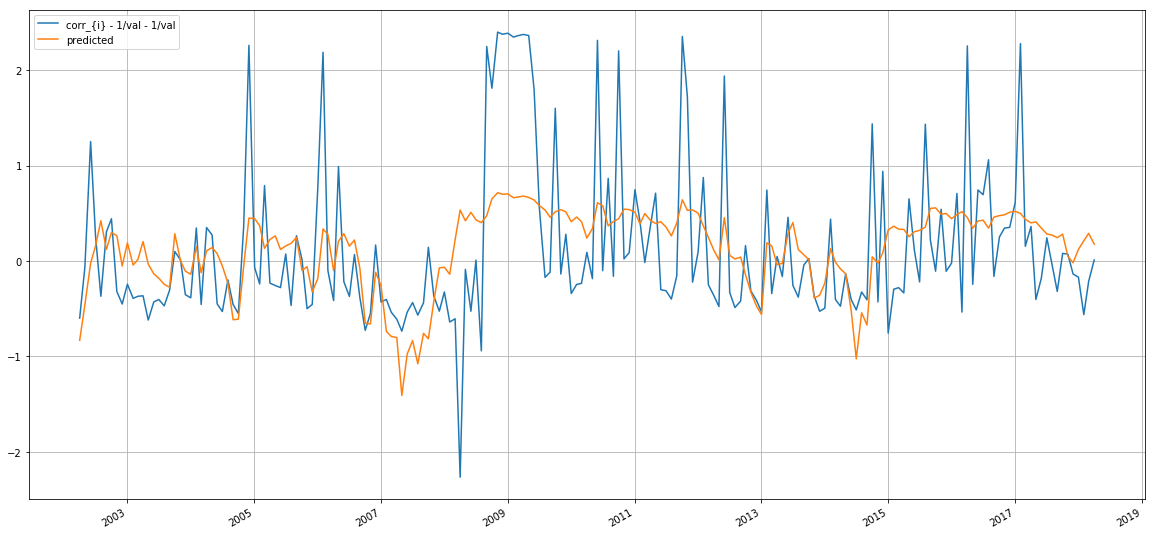

In [69]:
# align.plot(**meta_setup)
pre = pd.DataFrame(res.predict(), index=align.index, columns=['predicted'])
pd.merge(align[['corr_{i} - 1/val - 1/val']], pre, right_index=True, left_index=True).plot(**meta_setup)

In [24]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     corr_{i} - 1/val - 1/val   R-squared:                       0.236
Model:                                  OLS   Adj. R-squared:                  0.232
Method:                       Least Squares   F-statistic:                     59.15
Date:                      Wed, 18 Apr 2018   Prob (F-statistic):           7.55e-13
Time:                              14:13:12   Log-Likelihood:                -212.50
No. Observations:                       193   AIC:                             429.0
Df Residuals:                           191   BIC:                             435.5
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7406      0.095      7.822      0.000       0.554       0.927
1/val*val    -20.4066      2.653     -7.691      0.000     -25.640     -15.173
==============================================================================
Omnibus:                       24.663   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.264
Skew:                           0.771   Prob(JB):                     3.63e-08
Kurtosis:                       4.373   Cond. No.                         50.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
f = all_vix[sigma_vix].dropna()
#f["IMDOT1M"] = f['USDKRWV1M Curncy  (R2)'].multiply(f['USDTWDV1M Curncy'])
def chi2normal_transformation(df):
    risk_factor = pd.DataFrame(chi2.cdf(df, pd.rolling_mean(df, 150)), columns=df.columns, index=df.index)
    risk_factor = (risk_factor - pd.expanding_mean(risk_factor))
    return risk_factor

In [119]:
from scipy import stats
stats.percentileofscore(f.iloc[:40, 0], f.iloc[40, 0])

12.5

In [167]:
# Percentile score
window_size = 20
all_ = []
for i in range(window_size, f.shape[0]):
    rows = []
    for j in range(f.shape[1]):
        rows.append(stats.percentileofscore(f.iloc[:i, j], f.iloc[i, j]))
    all_.append(rows)

In [168]:
temp = pd.DataFrame(np.array(all_)/100, index=f.index[window_size:], columns=sigma_vix)

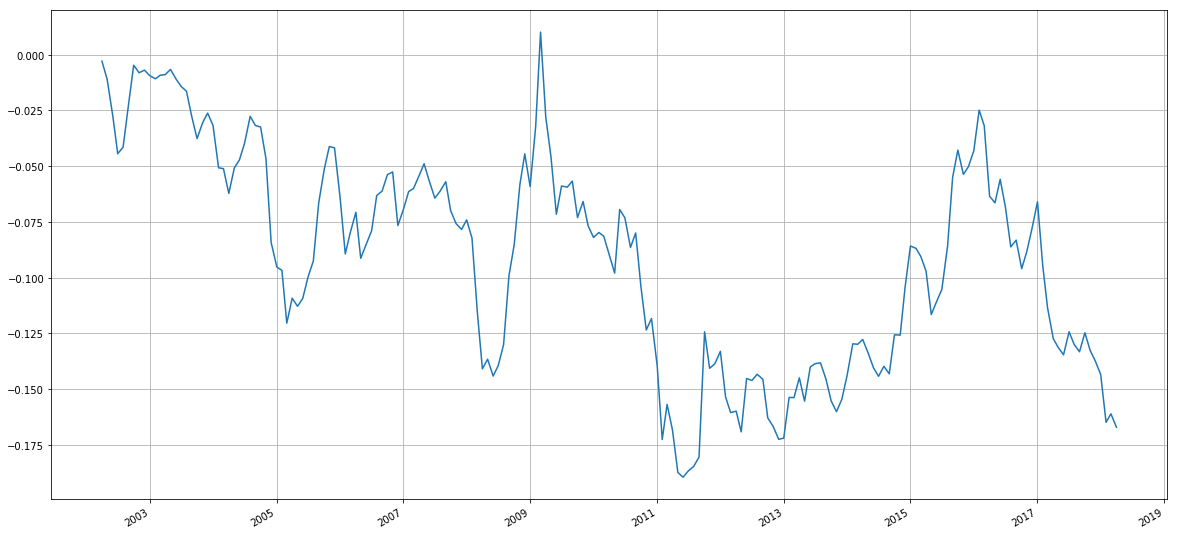

In [169]:
monthly_return['USD'].cumsum().plot(**meta_setup)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000261A5129F28>,
      dtype=object)

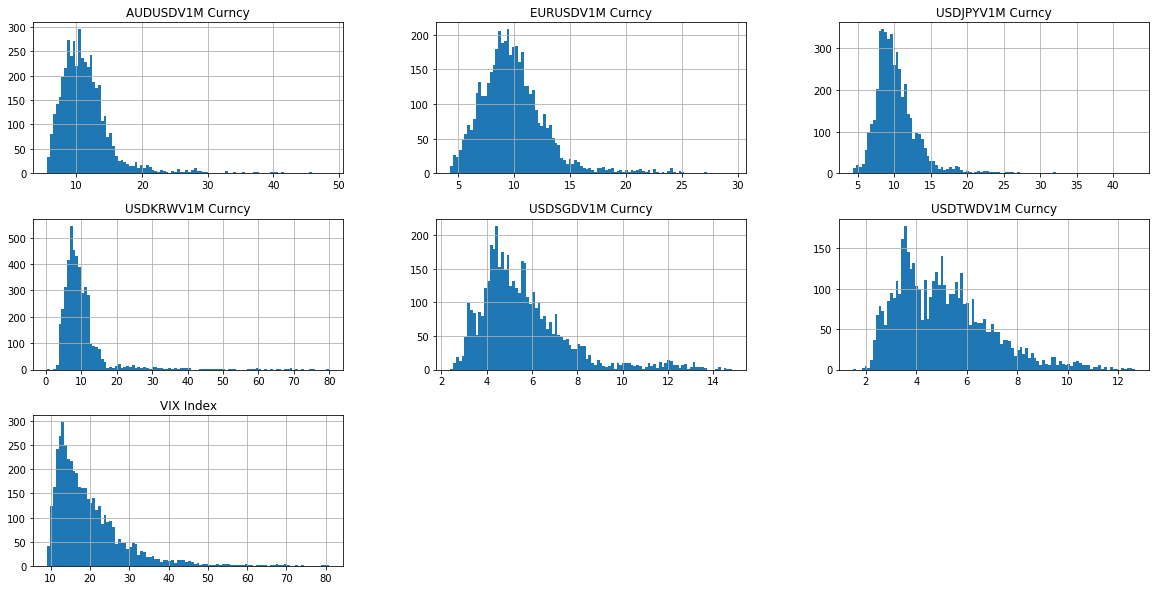

In [170]:
f.hist(bins=100, **meta_setup)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000261A55F5278>,
      dtype=object)

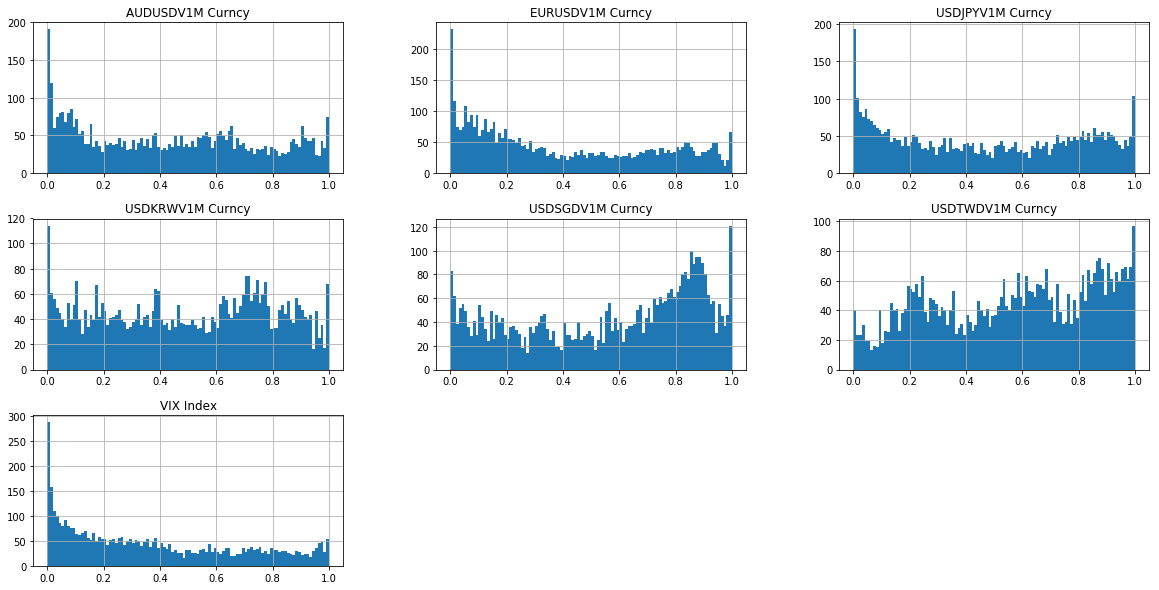

In [171]:
risk_factor = temp
risk_factor.hist(bins=100, **meta_setup)

$y_{t} = x_{0, t}\beta_{0} + x_{1, t}\beta_{1} + ..., \; s.t \; \text{some restrictions}$

$y_{t} = x_{0, t}(\beta_{0} + z_{0, t-1}\alpha_{0}) + x_{1, t}(\beta_{1} + z_{1, t-1}\alpha_{1}) +..., \; s.t \; \text{some restrictions}$

$y_{t} = x_{0, t}\beta_{0, t} + x_{1, t}\beta_{1, t} + ..., \; s.t \; \text{some restrictions}$

$\beta_{t} = \alpha\beta_{t-1} + \epsilon_{t}$

In [174]:
factor_target = pd.concat([monthly_return, risk_factor], 1).dropna()
monthly_return = factor_target[monthly_return.columns]
risk_factor = factor_target[risk_factor.columns]
#risk_factor = risk_factor.clip(-0.6, 0.6)

In [175]:
factor_target

,USD,JPY,AUD,KRW,XEU,SGD,GBP,VIX Index,AUDUSDV1M Curncy,USDJPYV1M Curncy,USDSGDV1M Curncy,EURUSDV1M Curncy,USDKRWV1M Curncy,USDTWDV1M Curncy
2002-04-01,-0.002877,-0.003290,-0.032560,0.000340,-0.006524,0.007808,-0.004764,0.002950,0.036873,0.140118,0.081121,0.008850,0.069322,0.100295
2002-05-01,-0.008142,-0.036387,-0.004100,-0.027395,-0.030084,-0.017499,-0.020719,0.307479,0.011080,0.005540,0.159280,0.117729,0.270083,0.206371
2002-06-03,-0.016649,-0.034024,-0.054616,-0.048380,-0.033373,-0.014447,0.000549,0.132812,0.217448,0.250000,0.373698,0.274740,0.557292,0.347656
2002-07-01,-0.016726,-0.033368,0.011945,-0.018346,-0.058592,-0.011750,-0.048527,0.673267,0.373762,0.883663,0.219059,0.821782,0.673267,0.570545
2002-08-01,0.002949,0.002335,0.042759,-0.017485,0.017474,-0.001189,-0.013149,0.908665,0.381733,0.469555,0.795082,0.497658,0.775176,0.907494
2002-09-02,0.019544,-0.016638,-0.024660,0.016443,-0.009368,-0.008219,0.002067,0.895323,0.278396,0.613586,0.652561,0.367483,0.456570,0.613586
2002-10-01,0.017189,0.034599,0.018467,0.021085,-0.004965,0.020518,-0.015702,0.972340,0.158511,0.739362,0.819149,0.274468,0.725532,0.713830
2002-11-01,-0.003380,0.002535,-0.026429,-0.000529,-0.004438,-0.010193,0.005369,0.768763,0.016227,0.271805,0.778905,0.087221,0.639959,0.677485
2002-12-02,0.001178,0.010521,-0.009439,-0.011858,0.000303,0.001415,0.006368,0.642023,0.003891,0.021401,0.169261,0.000000,0.323930,0.335603
2003-01-01,-0.002440,-0.042050,0.000178,-0.021774,-0.055015,-0.020171,-0.035606,0.684701,0.084888,0.677239,0.674440,0.514925,0.638993,0.553172


In [176]:
# Return Test
# dynamic estimate the correlation matrix
from model.passive_model import BasketModel, FactorDynamicBasketModel
initial_size = 40

portfolio = ["JPY", "AUD", "KRW", "XEU", "SGD", "GBP"]
target = "USD"

factor_maps = { 
    "JPY": ['VIX Index', 'USDJPYV1M Curncy', 'USDTWDV1M Curncy'],
    "AUD": ['VIX Index', 'AUDUSDV1M Curncy', 'USDTWDV1M Curncy'],
    "KRW": ['VIX Index', 'USDKRWV1M Curncy', 'USDTWDV1M Curncy'],
    "XEU": ['VIX Index', 'EURUSDV1M Curncy', 'USDTWDV1M Curncy'],
    "SGD": ['VIX Index', 'USDSGDV1M Curncy', 'USDTWDV1M Curncy'],
    "GBP": ['VIX Index', 'USDTWDV1M Curncy']
                }
agent1 = BasketModel(target="USD", 
                     portfolio=portfolio)

agent2 = FactorDynamicBasketModel(target="USD", 
                                  portfolio=portfolio, 
                                  factor_maps=factor_maps)

agents = [agent1, agent2]

time_index = []
rewards_dy = []
weighs_dy = []
bound_dy = []

for step in range(monthly_return.shape[0] - initial_size):
    r_temp = []
    w_temp = []
    b_temp = [] 
    for agent in agents:
        # prepare data
        if agent.__class__.__name__ == "BasketModel":
            batch_return = monthly_return.iloc[:step + initial_size]
            agent.train(batch_return[agent._target], batch_return[agent._portfolio])
            weight = agent.weights
            
        elif agent.__class__.__name__ == "FactorDynamicBasketModel":
            batch_returns = monthly_return.iloc[:step + initial_size]
            batch_factor = risk_factor.iloc[:step + initial_size]
            proxy_list = agent.making_features(portfolio_returns=batch_return[agent._portfolio],
                                               factors=batch_factor)
            target_proxy = pd.concat([batch_returns, proxy_list], 1).dropna()
            agent.train(target_proxy[agent._target], target_proxy.drop(agent._target, 1))

        new_state = monthly_return.iloc[step+initial_size]
        new_risk = risk_factor.iloc[:step+initial_size+1]
        proxy = new_state[agent._portfolio]
        target = new_state[agent._target]
        if agent.__class__.__name__ != "BasketModel":
            w = agent.dynamic_weights(new_risk)
            weight = w.iloc[-1]
        else:
            weight = agent._weights
        
        r = agent.reward(target, proxy, weight)
        bound = agent.residual_bound(target, proxy, weight, bendwidth=norm.interval(0.68)[1])
        r_temp.append(r)
        w_temp.append(weight)
        b_temp.append(bound)
        
    time_index.append(monthly_return.index[step + initial_size])    
    rewards_dy.append(r_temp)
    weighs_dy.append(w_temp)
    bound_dy.append(b_temp)
    

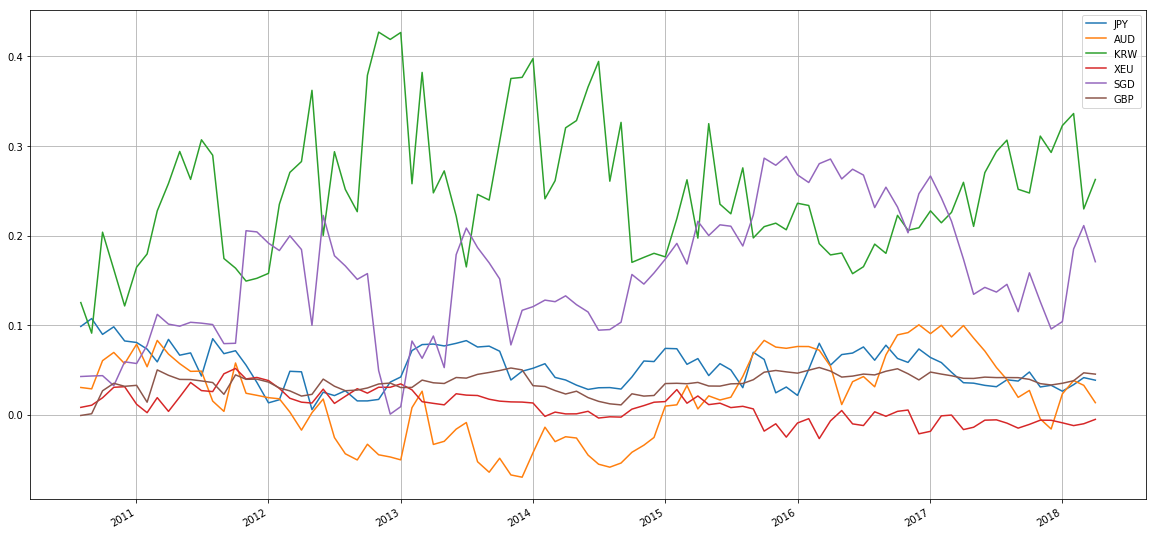

In [188]:
pd.DataFrame(np.array(weighs_dy)[:, 1, :], index=time_index, columns=portfolio).plot(**meta_setup)

In [178]:
rewards_dy = np.array(rewards_dy)

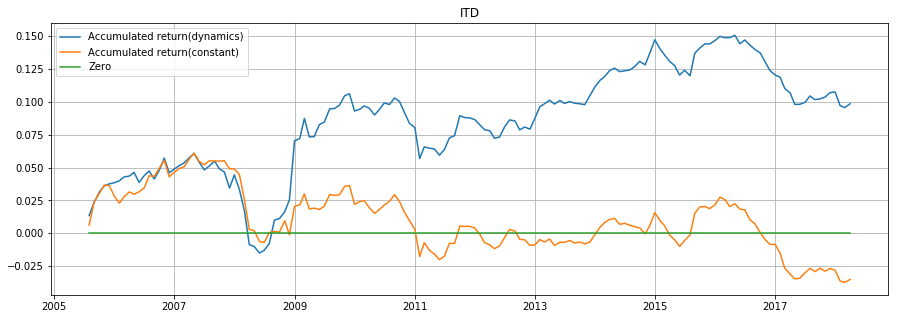

In [179]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(time_index, np.cumsum(rewards_dy[:, 1]), label='Accumulated return(dynamics)')
plt.plot(time_index, np.cumsum(rewards_dy[:, 0]), label='Accumulated return(constant)')
plt.plot(time_index, np.zeros_like(time_index), label="Zero")
plt.grid(True)
plt.legend()
plt.title("ITD")
plt.savefig('basket_result')

Text(0.5,1,'Monthly Returns: CI level=0.68')

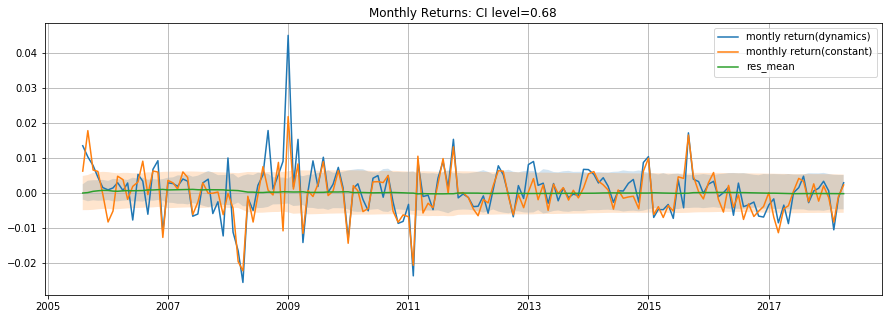

In [180]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(time_index, rewards_dy[:, 1], label='montly return(dynamics)')
plt.plot(time_index, rewards_dy[:, 0], label='monthly return(constant)')
plt.plot(time_index, np.array(bound_dy)[:, 0, :].mean(1), label="res_mean")
plt.fill_between(time_index, np.array(bound_dy)[:, 1, :][:, 0], np.array(bound_dy)[:, 1, :][:, 1], alpha=0.2)
plt.fill_between(time_index, np.array(bound_dy)[:, 0, :][:, 0], np.array(bound_dy)[:, 0, :][:, 1], alpha=0.2)
plt.grid(True)
plt.legend()
plt.title("Monthly Returns: CI level=0.68")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000261A7B42E48>,
      dtype=object)

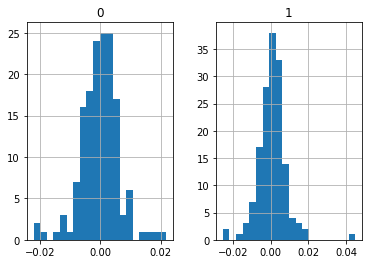

In [181]:
pd.DataFrame(rewards_dy).hist(bins=20)

In [182]:
# Return Test
# dynamic estimate the correlation matrix
from model.passive_model import BasketModel, FactorDynamicBasketModel, TVOLS
initial_size = 100

portfolio = ["JPY", "AUD", "KRW", "XEU", "SGD", "GBP"]
target = "USD"

factor_maps = { 
    "JPY": ['USDJPYV1M Curncy'],
    "AUD": ['AUDUSDV1M Curncy', 'USDTWDV1M Curncy'],
    "KRW": ['USDKRWV1M Curncy', 'USDTWDV1M Curncy'],
    "XEU": ['EURUSDV1M Curncy'],
    "SGD": ['USDSGDV1M Curncy'],
    "GBP": ['USDTWDV1M Curncy']
                }

agent1 = BasketModel(target="USD", 
                     portfolio=portfolio)

agent2 = FactorDynamicBasketModel(target="USD", 
                                  portfolio=portfolio, 
                                  factor_maps=factor_maps)
agent3 = TVOLS(target="USD", 
                     portfolio=portfolio)

agents = [agent1, agent2, agent3]

time_index = []
rewards_dy = []
weighs_dy = []
bound_dy = []

for step in range(monthly_return.shape[0] - initial_size):
    r_temp = []
    w_temp = []
    b_temp = [] 
    for agent in agents:
        # prepare data
        if agent.__class__.__name__ == "BasketModel":
            batch_return = monthly_return.iloc[:step + initial_size]
            agent.train(batch_return[agent._target], batch_return[agent._portfolio])
            weight = agent.weights
            
        elif agent.__class__.__name__ == "FactorDynamicBasketModel":
            batch_returns = monthly_return.iloc[:step + initial_size]
            batch_factor = risk_factor.iloc[:step + initial_size]
            proxy_list = agent.making_features(portfolio_returns=batch_return[agent._portfolio],
                                               factors=batch_factor)
            target_proxy = pd.concat([batch_returns, proxy_list], 1).dropna()
            agent.train(target_proxy[agent._target], target_proxy.drop(agent._target, 1))
            
        elif agent.__class__.__name__ == "TVOLS":
                batch_return = monthly_return.iloc[:step + initial_size]
                res = agent.fit(batch_return[agent._portfolio], batch_return[[agent._target]])
                

        new_state = monthly_return.iloc[step+initial_size]
        new_risk = risk_factor.iloc[:step+initial_size+1]
        proxy = new_state[agent._portfolio]
        target = new_state[agent._target]

        if agent.__class__.__name__ == "FactorDynamicBasketModel":
            w = agent.dynamic_weights(new_risk)
            weight = w.iloc[-1]
        elif agent.__class__.__name__ == "BasketModel":
            weight = agent._weights
        elif agent.__class__.__name__ == "TVOLS":
            weight = np.array(res[0])[-1]
        r = agent.reward(target, proxy, weight)
        #bound = agent.residual_bound(target, proxy, weight, norm.interval(0.68)[1])
        r_temp.append(r)
        w_temp.append(weight)
        #b_temp.append(bound)
        
    time_index.append(monthly_return.index[step + initial_size])    
    rewards_dy.append(r_temp)
    weighs_dy.append(w_temp)
    bound_dy.append(b_temp)

In [183]:
rewards_dy = np.array(rewards_dy)

Text(0.5,1,'Monthly Returns: CI level=0.68')

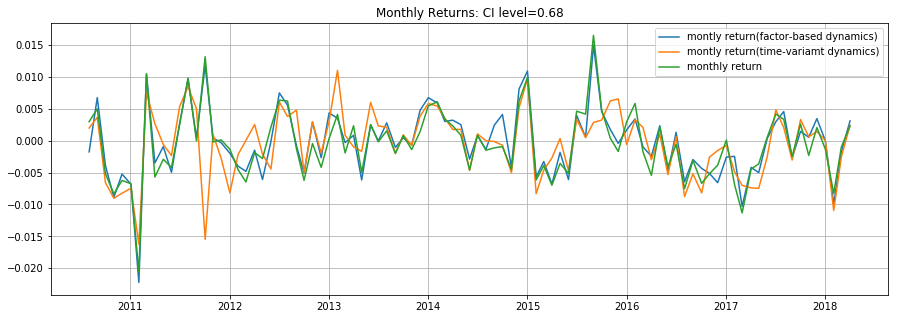

In [184]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(time_index, rewards_dy[:, 1], label='montly return(factor-based dynamics)')
plt.plot(time_index, rewards_dy[:, 2], label='montly return(time-variamt dynamics)')
plt.plot(time_index, rewards_dy[:, 0], label='monthly return')
#plt.plot(time_index, np.array(bound_dy)[:, 0, :].mean(1), label="res_mean")
#plt.fill_between(time_index, np.array(bound_dy)[:, 1, :][:, 0], np.array(bound_dy)[:, 1, :][:, 1], alpha=0.2)
#plt.fill_between(time_index, np.array(bound_dy)[:, 0, :][:, 0], np.array(bound_dy)[:, 0, :][:, 1], alpha=0.2)
plt.grid(True)
plt.legend()
plt.title("Monthly Returns: CI level=0.68")

Text(0.5,1,'Monthly Returns: CI level=0.68')

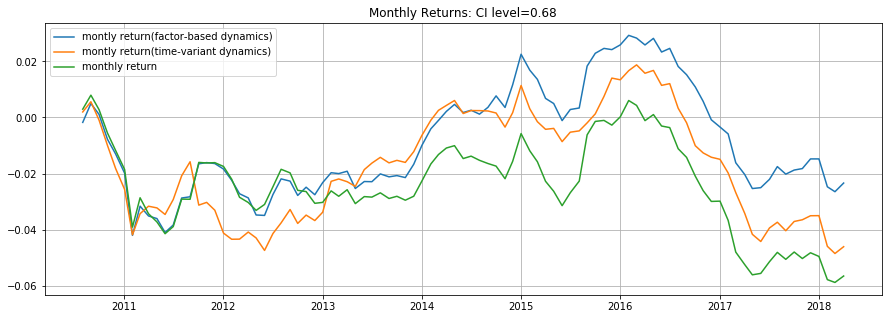

In [185]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(time_index, np.cumsum(rewards_dy[:, 1]), label='montly return(factor-based dynamics)')
plt.plot(time_index, np.cumsum(rewards_dy[:, 2]), label='montly return(time-variant dynamics)')
plt.plot(time_index, np.cumsum(rewards_dy[:, 0]), label='monthly return')
#plt.plot(time_index, np.array(bound_dy)[:, 0, :].mean(1), label="res_mean")
#plt.fill_between(time_index, np.array(bound_dy)[:, 1, :][:, 0], np.array(bound_dy)[:, 1, :][:, 1], alpha=0.2)
#plt.fill_between(time_index, np.array(bound_dy)[:, 0, :][:, 0], np.array(bound_dy)[:, 0, :][:, 1], alpha=0.2)
plt.grid(True)
plt.legend()
plt.title("Monthly Returns: CI level=0.68")

Text(0.5,1,'Model=Dynamic: Histogram of returns of each month')

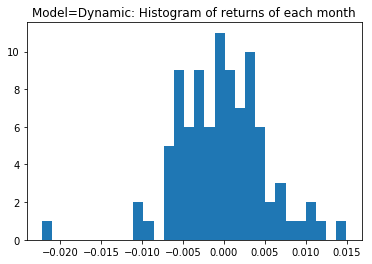

In [186]:
plt.hist(np.array(rewards_dy)[:, 1], 30)
plt.title("Model=Dynamic: Histogram of returns of each month")

In [187]:
dynamic_rw = np.array(rewards_dy)[:, 1]

In [141]:
# Look at the model break period 
lb = np.array(bound_dy)[:, 1, :][:, 0]
ub = np.array(bound_dy)[:, 1, :][:, 1]
dynamic_rw = np.array(rewards_dy)[:, 1]
model_break = np.array(time_index)[np.logical_or(dynamic_rw < lb, dynamic_rw > ub)]
break_reward = dynamic_rw[np.logical_or(dynamic_rw < lb, dynamic_rw > ub)]

IndexError: too many indices for array

In [142]:
pd.DataFrame(break_reward, columns=["reward"], index=model_break).to_excel("./data/model_failed_ci0.68.xls")

NameError: name 'break_reward' is not defined

In [143]:
plt.hist([d.month for d in model_break], bins=12)
plt.title("Failed Month histogram")

NameError: name 'model_break' is not defined

In [ ]:
print(agents[1].fitted_model["result"].summary())

In [ ]:
print(agents[0].fitted_model["result"].summary())

In [ ]:
monthly_return.loc[monthly_return.index[monthly_return.index.year>2016]]

In [ ]:
rewards_dy[:, 1]

In [ ]:
for step in range(monthly_return.shape[0] - initial_size):
    r_temp = []
    w_temp = []
    b_temp = [] 
    for agent in agents:
        # prepare data
        if agent.__class__.__name__ == "BasketModel":
            batch_return = monthly_return.iloc[:step + initial_size]
            agent.train(batch_return[agent._target], batch_return[agent._portfolio])
            weight = agent.weights
            
        elif agent.__class__.__name__ == "FactorDynamicBasketModel":
            batch_returns = monthly_return.iloc[:step + initial_size]
            batch_factor = risk_factor.iloc[:step + initial_size]
            proxy_list = agent.making_features(portfolio_returns=batch_return[agent._portfolio],
                                               factors=batch_factor)
            target_proxy = pd.concat([batch_returns, proxy_list], 1).dropna()
            agent.train(target_proxy[agent._target], target_proxy.drop(agent._target, 1))

        new_state = monthly_return.iloc[step+initial_size]
        new_risk = risk_factor.iloc[:step+initial_size+1]
        proxy = new_state[agent._portfolio]
        target = new_state[agent._target]
        if agent.__class__.__name__ != "BasketModel":
            w = agent.dynamic_weights(new_risk)
            weight = w.iloc[-1]
        else:
            weight = agent._weights
        
        r = agent.reward(target, proxy, weight)
        bound = agent.residual_bound(target, proxy, weight, bendwidth=norm.interval(0.68)[1])
        r_temp.append(r)
        w_temp.append(weight)
        b_temp.append(bound)
        
    time_index.append(monthly_return.index[step + initial_size])    
    rewards_dy.append(r_temp)
    weighs_dy.append(w_temp)
    bound_dy.append(b_temp)

In [31]:
# Numerical Calculation of Correlation matrix
X = np.random.normal(size=(1000, 5))

#  
np.var(Z, 0)
omega = np.diag(1/np.std(Z, 0))
omega.dot(Z.T.dot(Z).dot(omega))/1000

#
Z = X - X.mean(0)
Z.T.dot(Z)/(1000-1)

#
np.corrcoef(X.T)
np.cov(X.T)